# BLU06  - Exercise Notebook 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
idx = pd.IndexSlice
warnings.simplefilter(action='ignore', category=FutureWarning)   
from random import seed
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error
import math
from sklearn.ensemble import GradientBoostingRegressor
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import stattools
import hashlib # for grading purposes
from sklearn.model_selection import ParameterGrid

from pandas.plotting import lag_plot
from statsmodels.tsa.arima_model import ARIMA
plt.rcParams['figure.figsize'] = (12, 4)

%matplotlib inline

# Functions

These functions will be necessary for the exercises. The only one you'll use is _predict_n_periods_. The others are used by the latter.

In [ ]:
def build_target(series_, number_of_periods_ahead):
    """ 
    takes a series, turned it into a dataframe, and adds a new column called target
    This column is the input series, lagged number_of_periods_ahead into the future
    """
    
    # make a copy 
    series_ = series_.copy()
    series_.name = 'customers'
    
    # make a dataframe from the series
    df_ = pd.DataFrame(series_)
    
    # the target column will be the input series, lagged into the future
    df_['target'] = series_.shift(-number_of_periods_ahead)
    return df_

In [ ]:
def separate_last_day(df_):
    
    """
    takes a dataset which has the target and features built 
    and separates it into the last day
    """
    # take the last period 
    last_period = df_.iloc[-1]
    
    # the last period is now a series, so it's name will be the timestamp
    training_data = df_.loc[df_.index < last_period.name]

    return last_period, training_data

In [ ]:
def build_some_features(df_, num_periods_lagged=1, num_periods_diffed=0, weekday=False, month=False, rolling=[], holidays=False): 
    """
    Builds some features by calculating differences between periods  
    """
    # make a copy 
    df_ = df_.copy()
        
    # for a few values, get the lags  
    for i in range(1, num_periods_lagged+1):
        # make a new feature, with the lags in the observed values column
        df_['lagged_%s' % str(i)] = df_['customers'].shift(i)
        
    # for a few values, get the diffs  
    for i in range(1, num_periods_diffed+1):
        # make a new feature, with the lags in the observed values column
        df_['diff_%s' % str(i)] = df_['customers'].diff(i)
    
    for stat in rolling:
        df_['rolling_%s'%str(stat)] = df_['customers'].rolling('7D').aggregate(stat)
        
    if weekday == True:
        df_['sin_weekday'] = np.sin(2*np.pi*df_.index.weekday/7)
        df_['cos_weekday'] = np.sin(2*np.pi*df_.index.weekday/7)
        
    if month == True:
        df_['sin_month'] = np.sin(2*np.pi*df_.index.month/12)
        df_['cos_month'] = np.sin(2*np.pi*df_.index.month/12)
        
    if holidays == True:
        holidays = df_[((df_.index.month==12) & (df_.index.day==25))
              |((df_.index.month==1) & (df_.index.day==1))].customers
        df_['holidays'] = holidays + 1
        df_['holidays'] = df_['holidays'].fillna(0)
    
    return df_

In [ ]:
def separate_train_and_test_set(last_period_, training_data_, target='target'): 
    
    """ 
    separates training and test set (clue was in the name, really... )
    Ok, we were lazy and left the target hardcoded as 'target'. Shame on us. 
    """
    
    # anything that isn't a target is a feature 
    features = [feature for feature in training_data_.columns if feature != target]
    
    # adding a sneaky little dropna to avoid the missing data problem above 
    X_train = training_data_.dropna()[features]
    y_train = training_data_.dropna()[target]
    
    X_last_period = last_period_[features]
    
    return X_train, y_train, X_last_period

In [ ]:
def prepare_for_prediction(series_, number_of_periods_ahead, num_periods_lagged, num_periods_diffed, weekday, month, rolling, holidays):
    
    """ 
    Wrapper to go from the original series to X_train, y_train, X_last_period 
    
    """
    
    # build the target 
    data_with_target = build_target(series_, 
                                    number_of_periods_ahead)
    
    # build the features 
    data_with_target_and_features = build_some_features(data_with_target, 
                                                        num_periods_lagged=num_periods_lagged,
                                                       num_periods_diffed=num_periods_diffed,
                                                       weekday=weekday,
                                                       month=month,
                                                       rolling=rolling,
                                                       holidays=holidays)
    # separate train and test data 
    last_period, training_data = separate_last_day(data_with_target_and_features)

    # separate X_train, y_train, and X_test 
    X_train, y_train, X_last_period = separate_train_and_test_set(last_period, 
                                                           training_data, 
                                                           target='target')
    
    # return ALL OF THE THINGS! (well, actually just the ones we need)
    return X_train, y_train, X_last_period 

In [ ]:
def predict_period_n(series_, model, number_of_periods_ahead, num_periods_lagged, num_periods_diffed, weekday, month, rolling, holidays): 
    
        X_train, y_train, X_last_period = prepare_for_prediction(series_, 
                                                             number_of_periods_ahead, 
                                                             num_periods_lagged,
                                                             num_periods_diffed,
                                                             weekday,
                                                             month,
                                                             rolling,
                                                             holidays)
        
        model.fit(X_train, y_train)
        return model.predict(X_last_period.values.reshape(1, -1))

In [ ]:
def predict_n_periods(series_, n_periods, model, num_periods_lagged, num_periods_diffed=0, weekday=False, month=False,rolling=[], holidays=False): 
    predictions = []

    for period_ahead in range(1, n_periods+1):
        pred = predict_period_n(series_=series_, 
                                model=model, 
                                number_of_periods_ahead=period_ahead, 
                                num_periods_lagged=num_periods_lagged,
                                num_periods_diffed=num_periods_diffed,
                                weekday=weekday,
                                month=month,
                                rolling=rolling,
                                holidays=holidays)
        
        predictions.append(pred[0])
        
    return predictions 

# Let's predict store customers!

In [2]:
store = pd.read_csv('data/stores_exercise.csv')
store['date'] = pd.to_datetime(store['date'])
store = store.set_index('date')
store = store.sort_index()
store = store[:-180]

##### Plot the series to get an idea of what's going on

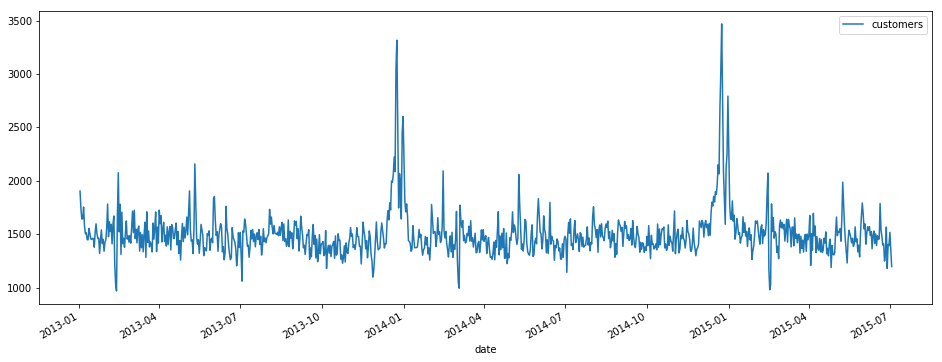

In [3]:
store.plot(figsize=(16, 6));

### Q1: Are there any missing days in the time series? If so, inspect them and decide how to fill them.

In [ ]:
# hint1: if the missing dates are holidays you can fill them with 0, since that's
# indication that the store was closed.

# hint2: the missing_value_mask should be a boolean Pandas Series with True or False according to if the value
# missing or not.

# hint3: the missing_value_dates should be a DatetimeIndex with the dates with missing values.

# store_resampled = 
# missing_value_mask =
# missing_value_dates = 
# store_cleaned = 

# YOUR CODE HERE
raise NotImplementedError()

In [40]:
store.index.shape[0]

909

In [12]:
(pd.to_datetime('2015-07-03')-pd.to_datetime('2013-01-01')).days

913

In [26]:
store_resampled = store.resample('D').mean()
store_resampled[store_resampled.customers.isnull()]

,customers
date,
2013-12-25,NaN
2014-01-01,NaN
2014-12-25,NaN
2015-01-01,NaN


In [34]:
missing_value_dates = store_resampled[store_resampled.customers.isnull()].index

In [35]:
store_cleaned = store_resampled.fillna(0)

In [36]:
store_cleaned.customers.loc['2014-01-01']

0.0

In [37]:
expected_hash = 'e9f26ecc6d60870d336e555719e6024c19a07e62c9e7174c36c42b847d50936a'
assert hashlib.sha256(str(missing_value_dates).encode()).hexdigest() == expected_hash

expected_hash = '2fb0b380648291dc9583422cf46dc3b682caaa881b076ff48e4d78f6f26e6898'
assert hashlib.sha256(str(store_cleaned).encode()).hexdigest() == expected_hash

### Q2: Formulate it as time series one-step-ahead prediction

### Q2.1 Create the target, 3 lags and drop the missing values.

In [41]:
# store_features = store_cleaned.copy()
# store_features['lag1'] = 
# store_features['lag2'] = 
# store_features['lag3'] = 
# store_features['target'] =
# store_features = 

# YOUR CODE HERE
store_features = store_cleaned.copy()
store_features['lag1'] = store_features.customers.shift(1)
store_features['lag2'] = store_features.customers.shift(2)
store_features['lag3'] = store_features.customers.shift(3)
store_features['target'] = store_features.customers.shift(-1)
store_features = store_features.dropna()

In [42]:
expected_hash = 'a7b263d903e5a6236b7bb778d31fae57462c18f6d888459a9ade11406c1d3729'
assert hashlib.sha256(str(store_features.shape).encode()).hexdigest() == expected_hash

### Q2.2 Separate the training and test set. The test set consists of the last 60 values, while the training set consists of the rest.

In [43]:
# note: this is a very straightforward question. But you may think: "isn't this one-step-ahead forecasting? 
# Why does the test have 60 values" Well, basically this just means we are doing 60 one-step-ahead forecasts.
# This way we obtain a better estimate of how our one-step-ahead model would perform in real life.

# store_train =
# store_test =

# YOUR CODE HERE
test_size = 60
store_train = store_features[:-test_size]
store_test = store_features[-test_size:]

In [44]:
expected_hash = '0d597dc2afbcf77932523efe4fa118591cbc3f691191c2471ae95e465c918dd3'
assert hashlib.sha256(str(store_train.index[-1]).encode()).hexdigest() == expected_hash

expected_hash = '23a57d8694a6eb61e0232c384c6939676cf8f8d515298f7f388b9071c22af223'
assert hashlib.sha256(str(store_test.index[0]).encode()).hexdigest() == expected_hash

### Q2.3 Fit a linear regression to the training set

In [ ]:
# X_store_train = 
# y_store_train =
# model =
# model.fit()

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
expected_hash = '0f770c90e52409c91f4805eb0998bb9d76d28ebd9e37a8f6e5c1bc6cc6231081'
assert hashlib.sha256(str(X_store_train.shape).encode()).hexdigest() == expected_hash

expected_hash = 'b823515f669540cbcf1e9244e5671f14534c9c562175db731e5fb5e4599bbd8c'
assert hashlib.sha256(str(y_store_train.shape).encode()).hexdigest() == expected_hash

expected_hash = '86875b6d65b929521f16ab8bc45e2fac898ea38ec7746836682655e32eecca7d'
assert hashlib.sha256(str(np.round(model.coef_,1)).encode()).hexdigest() == expected_hash

### Q2.4 Predict the test set and calculate the MAE

In [ ]:
# X_store_test =
# y_store_test = 
# y_predict = 
# test_mae = 

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
expected_hash = 'a838706ef29b226d8f8222bf3d9dac1e28db739da1196180209956ee02da8bae'
assert hashlib.sha256(str(X_store_test.shape).encode()).hexdigest() == expected_hash

expected_hash = '9053d01727f35cfdbbbd7284dba5e54ee557e5fc33084045dbc6fec2cb8730f7'
assert hashlib.sha256(str(y_store_test.shape).encode()).hexdigest() == expected_hash

expected_hash = '8c1f1046219ddd216a023f792356ddf127fce372a72ec9b4cdac989ee5b0b455'
assert hashlib.sha256(str(np.int(test_mae)).encode()).hexdigest() == expected_hash

### Q3 Let's go into multi-step prediction!

### Q3.1 Separate the data into train and test. Use the _predict_n_periods_ function to predict 60 steps ahead using linear regression. Then, calculate the MAE for the test set.

In [ ]:
# Use the same number of lags you used in the previous questions. Use no other features.

# store_multistep_train = 
# store_multistep_test =
# predictions = 
# test_mae = 

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
expected_hash = '299fe0f9c075c40a21029166ce1bd2046db47fcb639a2a13240b5d974961cb0b'
assert hashlib.sha256(str(store_multistep_train.shape).encode()).hexdigest() == expected_hash

expected_hash = '01f6bb906f864c80f90afb9e7d9071b6f6e7222bf67f2de6bce28f55981fbab4'
assert hashlib.sha256(str(store_multistep_test.shape).encode()).hexdigest() == expected_hash

expected_hash = 'c010bb0f7f8f335ccb2bc4e598eee48be11f87ac60a39a1a1cb4185688857003'
assert hashlib.sha256(str(np.int(predictions[-1])).encode()).hexdigest() == expected_hash

expected_hash = 'ad57366865126e55649ecb23ae1d48887544976efea46a48eb5d85a6eeb4d306'
assert hashlib.sha256(str(np.int(test_mae)).encode()).hexdigest() == expected_hash

### Q3.2 Separate into train, val and test. Test corresponds to the last 60 values and Val corresponds to the 60 steps before test.

In [ ]:
# hint: use the cleaned dataset

# store_multistep_train =
# store_multistep_val =
# store_multistep_test = 

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
expected_hash = '98eb165d180aa2cd9255f5a5151c101fac78fba9ce6c24421daa8b64ca2a0288'
assert hashlib.sha256(str(store_multistep_train.shape).encode()).hexdigest() == expected_hash

expected_hash = '01f6bb906f864c80f90afb9e7d9071b6f6e7222bf67f2de6bce28f55981fbab4'
assert hashlib.sha256(str(store_multistep_val.shape).encode()).hexdigest() == expected_hash

expected_hash = '01f6bb906f864c80f90afb9e7d9071b6f6e7222bf67f2de6bce28f55981fbab4'
assert hashlib.sha256(str(store_multistep_test.shape).encode()).hexdigest() == expected_hash

### Q3.3 Are the day of the week, the month of the year  and one-day diff useful features to the model?

In [ ]:
# Create a parameter grid using the gradient boosting regressor as a model. 
# Use 1 lag, holidays=True and no rollings.
# Use random state = 1 for the gradient boosting regressor
# Use a for cycle to find the group of params that minimizes the MAE on the validation set.

# hint: to have no rollings in the predict_n_periods you should send an empty lists of lists: [[]]


#param_grid = 

# grid = 

# for params in grid:
     # predictions =
                                    
# best_params = 

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
expected_hash = '3cbc87c7681f34db4617feaa2c8801931bc5e42d8d0f560e756dd4cd92885f18'
assert hashlib.sha256(str(best_params['weekday']).encode()).hexdigest() == expected_hash

expected_hash = '3cbc87c7681f34db4617feaa2c8801931bc5e42d8d0f560e756dd4cd92885f18'
assert hashlib.sha256(str(best_params['month']).encode()).hexdigest() == expected_hash

expected_hash = '6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d49c01e52ddb7875b4b'
assert hashlib.sha256(str(best_params['num_periods_diffed']).encode()).hexdigest() == expected_hash


### Q3.5 Train a model with the best combination and predict the test set. Calculate the corresponding MAE.

In [ ]:
# use random_state=1 in the gradient boosting regressor.

# store_multistep_train_val = 
# predictions = 
# test_mae = 

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
expected_hash = '8241649609f88ccd2a0a5b233a07a538ec313ff6adf695aa44a969dbca39f67d'
assert hashlib.sha256(str(np.int(test_mae)).encode()).hexdigest() == expected_hash